In [1]:
import math
from itertools import product

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1663095636739_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.uninstall_package('pip')
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("opencv-python") #Install opencv-python 
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Uninstalling pip-9.0.1:
  Successfully uninstalled pip-9.0.1

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.37.1-py3-none-any.whl (957 kB)
  Using cached kiwisolver-1.4.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached Pillow-9.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached typing_extensions-4.3.0-py3-none-any.whl (25 kB)

In [3]:
def deg2num(lat_deg, lon_deg, zoom):
    '''
        Convert latitude, longitude to (x,y) tile coordinate at given zoom.
    '''
    lat_rad = math.radians(lat_deg)
    n = 2.0**zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
def num2deg(xtile, ytile, zoom):
    '''
        Convert (x,y) to latitude, longitude tile coordinate at given zoom.
    '''
    n = 2.0**zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
def tiles_url(zoom, lat1, lon1, lat2, lon2):
    ''' 
        Convert geographic bounds into a list of tile_url coordinates at given zoom.
    '''
    # convert to geographic bounding box
    minlat, minlon = min(lat1, lat2), min(lon1, lon2)
    maxlat, maxlon = max(lat1, lat2), max(lon1, lon2)

    # convert to tile-space bounding box
    xmin, ymin = deg2num(maxlat, minlon, zoom)
    xmax, ymax = deg2num(minlat, maxlon, zoom)

    # generate a list of tiles_url
    tiles_url = []
    for x in range(xmin, xmax + 1):
        for y in range(ymin, ymax + 1):
            tiles_url.append((f"s3://elevation-tiles-prod//terrarium/{zoom}/{x}/{y}.png"))
            

    return tiles_url, (xmax - xmin) + 1, (ymax - ymin) + 1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
def plot_img(img):
    plt.clf()
    plt.gray()
    plt.imshow(img)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def plot_map(combo,x_interval, y_interval):
    
    columns = [np.concatenate(combo[i*y_interval : (i+1)*y_interval], axis=0) for i in range(x_interval-1)]
    mapp = np.concatenate(columns, axis=1)
    
    plt.clf()
    #plt.gray()
    plt.imshow(mapp)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def get_height(data):
    (B, G, R) = cv2.split(data)
    a = (R * 256.0 + G + B/256.0) - 32768.0
    a = np.where(a>0, a, 0)
    return a


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [117]:
def create_groups(data):
    rdd = spark.sparkContext.parallelize(data)
    means = rdd.map(lambda x: cv2.mean(x)).sortBy(lambda x: x[0]).collect()

    amount = len(means)
    groups = []
    """
    Groups:
    0 -> 30% of values
    1 -> 30% - 45% of values
    2 -> 45% - 60% of values
    3 -> 60% - 80% of values
    4 -> 80% - 95% of values
    5 -> 90% - 100% of values
    
    """
    
    groups.append(means[int(95*amount/100)][0])
    groups.append(means[int(80*amount/100)][0])
    groups.append(means[int(60*amount/100)][0])
    groups.append(means[int(45*amount/100)][0])
    groups.append(means[int(30*amount/100)][0])
    
    return groups



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [121]:
def processing(arr_in, groups):
    arr = arr_in
    
    arr = np.where(arr_in >= groups[0], 0, arr)
    arr = np.where((groups[0] > arr_in) & (arr_in >= groups[1]), 1, arr)
    arr = np.where((groups[1] > arr_in) & (arr_in >= groups[2]), 2, arr)
    arr = np.where((groups[2] > arr_in) & (arr_in >= groups[3]), 3, arr)
    arr = np.where((groups[3] > arr_in) & (arr_in >= groups[4]), 4, arr)
    arr = np.where((groups[4] > arr_in), 5, arr)

    return arr
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def paint(data, groups):
    rdd = spark.sparkContext.parallelize(data)
    return rdd.map(lambda x: processing(x, groups)).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, asc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
def to_idx(file):
    out = int(file.split("/")[5])
    return out

def to_idy(file):
    out = file.split("/")[6]
    out = int(out.split(".")[0])
    return out

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [123]:
def main():
    
    AMERICA = (72.0, -168.0, -54.0, -25.0)
    TEST = (30, -85, 24, -79)
    
    data, x_interval, y_interval = tiles_url(5, *AMERICA)
    
    
    input_data = spark.read.format("image").load(data)
    input_data2 = input_data.select("image.origin", "image.data")
    
    new_idx = F.udf(to_idx, IntegerType())
    new_idy = F.udf(to_idy, IntegerType())

    input_data2 = input_data2.withColumn("idx", new_idx("origin"))
    input_data2 = input_data2.withColumn("idy", new_idy("origin"))
    input_data2 = input_data2.orderBy(col("idx").asc(), col("idy").asc())
    
    images = input_data2.select("data") #taking only sorted data = pixels
    
    
    images = images.rdd.map(lambda img: np.reshape(img, (256,256,3))) #images<dateframe> to images<rdd>
    images = images.map(get_height) 
          
    # gradient 
    gX = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 1, 0))
    gY = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 0, 1))

    gx = np.asarray(gX.take(gX.count()))
    gy = np.asarray(gY.take(gY.count()))

    combined = np.sqrt(gx**2 + gy**2)


    groups = create_groups(combined)
  
    painted = paint(combined, groups)

    plot_map(painted, x_interval, y_interval)
    plt.imsave('colored.png', painted)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

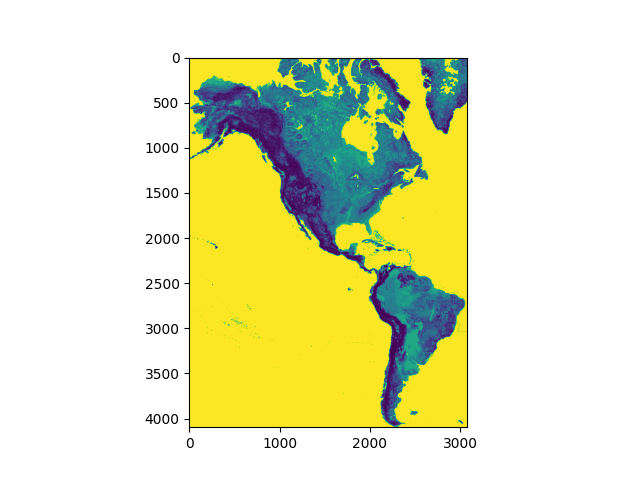

In [124]:
main()
%matplot plt